# Using Keras to Classify Images with a Convolutional Neural Network on IBM's Data Science Experience Local  
By: Michael Travis  
2017-08-01  
This notebook is a basic example of running a convolutional neural network on 1.2GB of images to classify 39 different species. The data was provided by iNaturalist for a Kaggle competition (https://www.kaggle.com/c/inaturalist-challenge-at-fgvc-2017/data). The model still has tons of room for improvement and looks like it may even be overfitting a bit, but it's a good staring spot to work from to develop a strong classifier.      
This notebook will be continued to be built upon to improve results and to use more data to truly test the capabilities of DSX Local.

## 1. Obtain Images
If this is your first time running this notebook, the cells below will obtain the images then decompress and save them to your working directory.

In [ ]:
if not os.path.isdir("train_val_images_mini"):
    !wget https://storage.googleapis.com/us_inat_data/train_val/train_val_images_mini.tar.gz

In [ ]:
if not os.path.isdir("train_val_images_mini") and os.path.isdir("train_val_images_mini.tar.gz"):
    !tar xzf train_val_images_mini.tar.gz && rm train_val_images_mini.tar.gz

## 2. Libraries

In [1]:
#Import all necessary libraries.
import glob
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D 
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


## 3. Overview of Data

In [2]:
#The species of which we will classify the images by.
!ls train_val_images_mini/*

train_val_images_mini/Actinopterygii:
Abudefduf saxatilis  Lepomis macrochirus  Zanclus cornutus

train_val_images_mini/Amphibia:
Acris blanchardi  Gastrophryne olivacea  Trachycephalus typhonius

train_val_images_mini/Animalia:
Acropora palmata  Megalorchestia californiana  Velella velella

train_val_images_mini/Arachnida:
Amblyomma americanum  Latrodectus geometricus  Verrucosa arenata

train_val_images_mini/Aves:
Acanthis flammea  Fregata minor  Zosterops lateralis lateralis

train_val_images_mini/Chromista:
Durvillaea antarctica  Hormosira banksii  Sargassum muticum

train_val_images_mini/Fungi:
Agrocybe parasitica  Gymnosporangium juniperi-virginianae  Xylaria polymorpha

train_val_images_mini/Insecta:
Abaeis nicippe	Eacles imperialis  Zopherus nodulosus haldemani

train_val_images_mini/Mammalia:
Acinonyx jubatus  Lycaon pictus  Zalophus californianus

train_val_images_mini/Mollusca:
Acanthodoris lutea  Euglandina rosea  Urosalpinx cinerea

train_val_images_mini/Plantae:
Abies bal

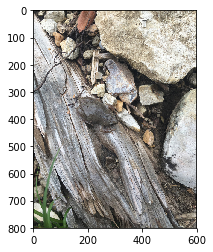

In [3]:
#A look at three of the images.
img1 = io.imread('train_val_images_mini/Amphibia/Gastrophryne olivacea/96d54335472ee70a4dbb482980c006e2.jpg')
plt.imshow(img1)

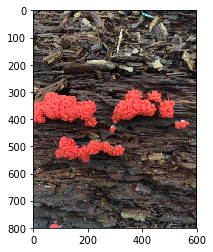

In [4]:
img2 = io.imread('train_val_images_mini/Protozoa/Tubifera ferruginosa/41eeae312f42b445e9e45a1fa0fb5b65.jpg')
plt.imshow(img2)

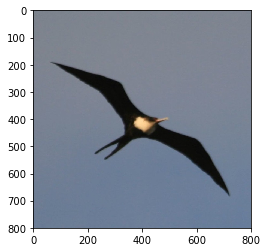

In [5]:
img3 = io.imread('train_val_images_mini/Aves/Fregata minor/147f3f06c313d4f485f97145fdecad6c.jpg')
plt.imshow(img3)

In [6]:
#Get number of species
sum_sp = 0
for path in glob.glob('train_val_images_mini/*'):
    sum_sp += len(os.listdir(path))
print("Number of species: " + str(sum_sp))

#Get number of images
sum_im = 0
for path in glob.glob('train_val_images_mini/*/*'):
    sum_im += len(os.listdir(path))
print("Number of images: " + str(sum_im))

NUM_IMAGES = sum_im
NUM_SPECIES = sum_sp
IM_ROWS = 224
IM_COLS = 224
RGB = 1

EPOCHS = 15
BATCH_SIZE = 32

Number of species: 39
Number of images: 3978


## 4. Read in Images  
You only need to run the first block in this section once, as it will save the numpy arrays. After your first time running it you can comment out the entire cell and un-comment the second cell, as it will load the arrays from your directory.

In [7]:
#Initilaize two numpy array for the images and labels.
X = np.empty(shape=(NUM_IMAGES,IM_ROWS,IM_COLS,RGB))
y = np.empty(shape=NUM_IMAGES)

#Empty dictionary for the species categories.
cats = {}

#Read in the images and re-size.
j=0
i=0
for filename in glob.glob('train_val_images_mini/*/*/*.jpg'):
    img = io.imread(filename,as_grey=True)
    species = filename.split('/')[2]
    if species not in cats:
        cats[species] = j
        j += 1
    X[i] = transform.resize(img, output_shape=(IM_ROWS,IM_COLS,RGB),mode='constant')
    y[i] = cats[species]
    i+=1
np.save('X.npy',X)
np.save('y.npy',y)

In [8]:
# X = np.load('X.npy')
# y = np.load('y.npy')

## 5. Pre-process Images and Split into Train/Test Sets

In [9]:
X = X.astype('float32')

#Scale.
X /= 255

#Mean subtraction.
X -= np.mean(X)

#Normalize.
X /= np.std(X, axis = 0)

#One-hot encode.
y = to_categorical(y, NUM_SPECIES)

In [10]:
#Stratify the split to ensure train and test contain each species.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, stratify=y)

## 6. Create, Fit and Evaluate Model
The model and layers selected will be explained in a later notebook after the model has been improved.

In [11]:
model = Sequential()

model.add(Conv2D(32,(3,3),padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_SPECIES))
model.add(Activation('softmax'))

#Initiate optimizer
opt = optimizers.SGD(lr=0.01)

#Compile Model
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [12]:
#Fit Model
model.fit(X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            shuffle=True)

Train on 3182 samples, validate on 796 samples
Epoch 1/15
3182/3182 [==============================] - 155s - loss: 3.3953 - acc: 0.1301 - val_loss: 3.1721 - val_acc: 0.1595

In [13]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 61.93%


## 7. Save Model

In [14]:
model_path = os.path.join('/user-home/1001/notebooks/model', 'cnnModel.h5')
model.save(model_path)

## 8. Sources  
1. https://github.com/visipedia/inat_comp#data
2. http://cs231n.github.io/convolutional-networks/
3. https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3